# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [33]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

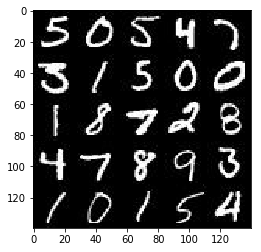

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

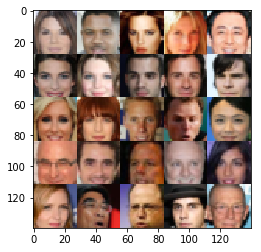

In [35]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function - DONE
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(),name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
#passing in 28*28*3 images to the discriminator
#returns output (Real or fake) and also, logits which are used to calculate cross entropy loss

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        ## 28x28x3
        layer_1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        # 14x14x64
        
        layer_2 = tf.layers.conv2d(layer_1, filters=128, kernel_size=4 , strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        # 7x7x128
        
        layer_3 = tf.layers.conv2d(layer_2, filters=256, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
        #4x4x256
        
        flattened = tf.reshape(layer_3, (-1, 4*4*256))
        #4096
        
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        layer_1 = tf.layers.dense(z, 7*7*512)
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, 2, 'same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, 2, 'same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
       
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, 1, 'same')        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_real)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{};".format(epoch_i + 1, epochs), "Discriminator Loss: {:.4f};".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4; Discriminator Loss: 1.6717; Generator Loss: 0.6158
Epoch 1/4; Discriminator Loss: 2.1264; Generator Loss: 0.4090
Epoch 1/4; Discriminator Loss: 2.2171; Generator Loss: 0.3127
Epoch 1/4; Discriminator Loss: 1.7816; Generator Loss: 0.5868
Epoch 1/4; Discriminator Loss: 1.8781; Generator Loss: 0.4472
Epoch 1/4; Discriminator Loss: 1.7690; Generator Loss: 0.8938
Epoch 1/4; Discriminator Loss: 1.6581; Generator Loss: 0.5847
Epoch 1/4; Discriminator Loss: 1.7730; Generator Loss: 0.3496
Epoch 1/4; Discriminator Loss: 1.6106; Generator Loss: 0.4764
Epoch 1/4; Discriminator Loss: 1.4472; Generator Loss: 0.5237


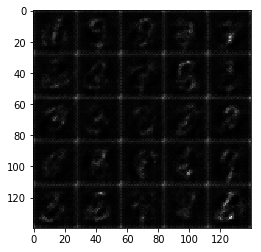

Epoch 1/4; Discriminator Loss: 1.4934; Generator Loss: 0.7093
Epoch 1/4; Discriminator Loss: 1.3365; Generator Loss: 1.0588
Epoch 1/4; Discriminator Loss: 1.5131; Generator Loss: 0.5046
Epoch 1/4; Discriminator Loss: 1.3782; Generator Loss: 1.0147
Epoch 1/4; Discriminator Loss: 1.4472; Generator Loss: 0.6287
Epoch 1/4; Discriminator Loss: 1.4847; Generator Loss: 0.8508
Epoch 1/4; Discriminator Loss: 1.5028; Generator Loss: 0.7880
Epoch 1/4; Discriminator Loss: 1.4810; Generator Loss: 0.9522
Epoch 1/4; Discriminator Loss: 1.5771; Generator Loss: 0.4454
Epoch 1/4; Discriminator Loss: 1.4631; Generator Loss: 0.7444


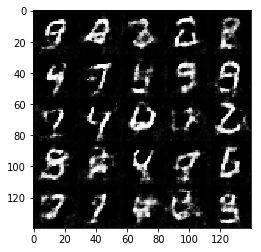

Epoch 1/4; Discriminator Loss: 1.5381; Generator Loss: 0.6592
Epoch 1/4; Discriminator Loss: 1.6496; Generator Loss: 0.3919
Epoch 1/4; Discriminator Loss: 1.4272; Generator Loss: 0.7852
Epoch 1/4; Discriminator Loss: 1.5284; Generator Loss: 1.1415
Epoch 1/4; Discriminator Loss: 1.5251; Generator Loss: 0.5027
Epoch 1/4; Discriminator Loss: 1.4757; Generator Loss: 0.5877
Epoch 1/4; Discriminator Loss: 1.4829; Generator Loss: 0.5905
Epoch 1/4; Discriminator Loss: 1.5363; Generator Loss: 0.4666
Epoch 1/4; Discriminator Loss: 1.5978; Generator Loss: 0.4274
Epoch 1/4; Discriminator Loss: 1.4652; Generator Loss: 0.7229


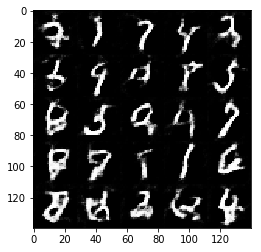

Epoch 1/4; Discriminator Loss: 1.4667; Generator Loss: 0.6016
Epoch 1/4; Discriminator Loss: 1.4358; Generator Loss: 0.7584
Epoch 1/4; Discriminator Loss: 1.5162; Generator Loss: 0.5680
Epoch 1/4; Discriminator Loss: 1.6477; Generator Loss: 0.4105
Epoch 1/4; Discriminator Loss: 1.5130; Generator Loss: 1.0092
Epoch 1/4; Discriminator Loss: 1.4694; Generator Loss: 0.5480
Epoch 1/4; Discriminator Loss: 1.4087; Generator Loss: 0.7904
Epoch 1/4; Discriminator Loss: 1.4233; Generator Loss: 0.8218
Epoch 1/4; Discriminator Loss: 1.5755; Generator Loss: 1.1396
Epoch 1/4; Discriminator Loss: 1.4414; Generator Loss: 0.7234


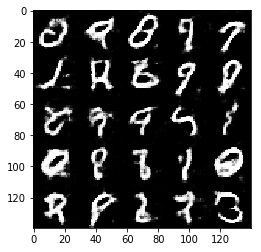

Epoch 1/4; Discriminator Loss: 1.4475; Generator Loss: 1.1458
Epoch 1/4; Discriminator Loss: 1.4501; Generator Loss: 0.6524
Epoch 1/4; Discriminator Loss: 1.4633; Generator Loss: 0.6464
Epoch 1/4; Discriminator Loss: 1.4806; Generator Loss: 0.5658
Epoch 1/4; Discriminator Loss: 1.4481; Generator Loss: 0.6367
Epoch 1/4; Discriminator Loss: 1.5574; Generator Loss: 0.4256
Epoch 2/4; Discriminator Loss: 1.4002; Generator Loss: 0.6951
Epoch 2/4; Discriminator Loss: 1.5594; Generator Loss: 0.4298
Epoch 2/4; Discriminator Loss: 1.4205; Generator Loss: 0.9101
Epoch 2/4; Discriminator Loss: 1.4194; Generator Loss: 0.9437


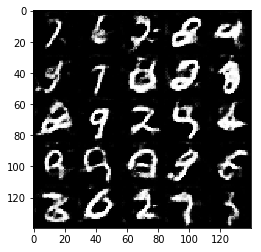

Epoch 2/4; Discriminator Loss: 1.4661; Generator Loss: 0.5433
Epoch 2/4; Discriminator Loss: 1.4693; Generator Loss: 0.9686
Epoch 2/4; Discriminator Loss: 1.4411; Generator Loss: 1.0481
Epoch 2/4; Discriminator Loss: 1.4080; Generator Loss: 0.9614
Epoch 2/4; Discriminator Loss: 1.4204; Generator Loss: 0.9015
Epoch 2/4; Discriminator Loss: 1.4208; Generator Loss: 0.9098
Epoch 2/4; Discriminator Loss: 1.4690; Generator Loss: 1.0652
Epoch 2/4; Discriminator Loss: 1.4308; Generator Loss: 0.5758
Epoch 2/4; Discriminator Loss: 1.4048; Generator Loss: 0.8532
Epoch 2/4; Discriminator Loss: 1.5616; Generator Loss: 0.4173


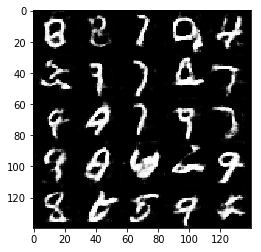

Epoch 2/4; Discriminator Loss: 1.5004; Generator Loss: 0.5082
Epoch 2/4; Discriminator Loss: 1.4111; Generator Loss: 0.5722
Epoch 2/4; Discriminator Loss: 1.4688; Generator Loss: 0.5585
Epoch 2/4; Discriminator Loss: 1.5622; Generator Loss: 1.3677
Epoch 2/4; Discriminator Loss: 1.4410; Generator Loss: 0.6701
Epoch 2/4; Discriminator Loss: 1.5856; Generator Loss: 0.4229
Epoch 2/4; Discriminator Loss: 1.4130; Generator Loss: 0.8234
Epoch 2/4; Discriminator Loss: 1.4335; Generator Loss: 0.6352
Epoch 2/4; Discriminator Loss: 1.6918; Generator Loss: 0.3493
Epoch 2/4; Discriminator Loss: 1.4325; Generator Loss: 0.8905


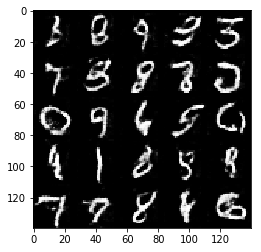

Epoch 2/4; Discriminator Loss: 1.5207; Generator Loss: 0.5445
Epoch 2/4; Discriminator Loss: 1.4578; Generator Loss: 1.0902
Epoch 2/4; Discriminator Loss: 1.4589; Generator Loss: 0.6247
Epoch 2/4; Discriminator Loss: 1.4269; Generator Loss: 0.6523
Epoch 2/4; Discriminator Loss: 1.5808; Generator Loss: 0.4175
Epoch 2/4; Discriminator Loss: 1.5317; Generator Loss: 0.4706
Epoch 2/4; Discriminator Loss: 1.4993; Generator Loss: 0.6024
Epoch 2/4; Discriminator Loss: 1.4399; Generator Loss: 0.6320
Epoch 2/4; Discriminator Loss: 1.3925; Generator Loss: 1.0268
Epoch 2/4; Discriminator Loss: 1.4351; Generator Loss: 0.7182


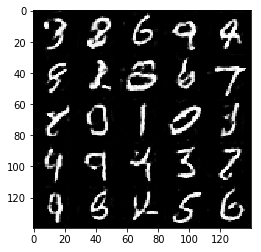

Epoch 2/4; Discriminator Loss: 1.4087; Generator Loss: 0.6448
Epoch 2/4; Discriminator Loss: 1.4500; Generator Loss: 0.5881
Epoch 2/4; Discriminator Loss: 1.3914; Generator Loss: 0.5920
Epoch 2/4; Discriminator Loss: 1.4657; Generator Loss: 0.5324
Epoch 2/4; Discriminator Loss: 1.2726; Generator Loss: 0.8748
Epoch 2/4; Discriminator Loss: 2.1587; Generator Loss: 1.4387
Epoch 2/4; Discriminator Loss: 1.3192; Generator Loss: 0.8879
Epoch 2/4; Discriminator Loss: 1.3544; Generator Loss: 0.6472
Epoch 2/4; Discriminator Loss: 1.4225; Generator Loss: 0.7840
Epoch 2/4; Discriminator Loss: 1.4317; Generator Loss: 0.5854


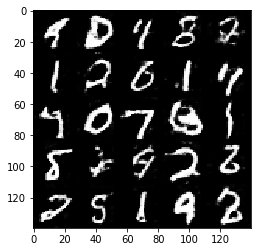

Epoch 2/4; Discriminator Loss: 2.0510; Generator Loss: 2.0210
Epoch 2/4; Discriminator Loss: 1.3308; Generator Loss: 0.6832
Epoch 2/4; Discriminator Loss: 1.3917; Generator Loss: 0.5515
Epoch 3/4; Discriminator Loss: 1.4341; Generator Loss: 0.7517
Epoch 3/4; Discriminator Loss: 1.3540; Generator Loss: 0.6289
Epoch 3/4; Discriminator Loss: 1.4314; Generator Loss: 1.0096
Epoch 3/4; Discriminator Loss: 1.3862; Generator Loss: 0.6861
Epoch 3/4; Discriminator Loss: 1.3899; Generator Loss: 0.6667
Epoch 3/4; Discriminator Loss: 1.5493; Generator Loss: 0.4315
Epoch 3/4; Discriminator Loss: 1.5393; Generator Loss: 0.4289


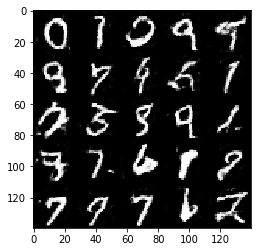

Epoch 3/4; Discriminator Loss: 1.6013; Generator Loss: 0.5822
Epoch 3/4; Discriminator Loss: 1.4085; Generator Loss: 0.7171
Epoch 3/4; Discriminator Loss: 1.4208; Generator Loss: 0.5723
Epoch 3/4; Discriminator Loss: 1.4088; Generator Loss: 0.5521
Epoch 3/4; Discriminator Loss: 1.4440; Generator Loss: 0.5361
Epoch 3/4; Discriminator Loss: 1.3170; Generator Loss: 0.8286
Epoch 3/4; Discriminator Loss: 1.4817; Generator Loss: 0.5278
Epoch 3/4; Discriminator Loss: 1.4463; Generator Loss: 1.2473
Epoch 3/4; Discriminator Loss: 1.5248; Generator Loss: 0.4504
Epoch 3/4; Discriminator Loss: 1.4150; Generator Loss: 0.5588


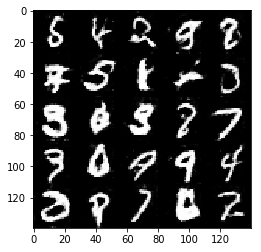

Epoch 3/4; Discriminator Loss: 1.4660; Generator Loss: 1.0098
Epoch 3/4; Discriminator Loss: 1.3223; Generator Loss: 0.5786
Epoch 3/4; Discriminator Loss: 1.2803; Generator Loss: 0.7804
Epoch 3/4; Discriminator Loss: 1.4453; Generator Loss: 0.5633
Epoch 3/4; Discriminator Loss: 1.2986; Generator Loss: 1.0249
Epoch 3/4; Discriminator Loss: 1.3516; Generator Loss: 0.5915
Epoch 3/4; Discriminator Loss: 1.3701; Generator Loss: 0.8986
Epoch 3/4; Discriminator Loss: 1.5936; Generator Loss: 0.3904
Epoch 3/4; Discriminator Loss: 1.4058; Generator Loss: 0.8338
Epoch 3/4; Discriminator Loss: 1.3382; Generator Loss: 0.8409


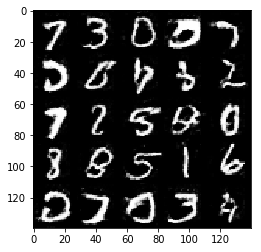

Epoch 3/4; Discriminator Loss: 1.4766; Generator Loss: 0.4635
Epoch 3/4; Discriminator Loss: 1.4290; Generator Loss: 0.4909
Epoch 3/4; Discriminator Loss: 1.3698; Generator Loss: 0.9024
Epoch 3/4; Discriminator Loss: 1.4346; Generator Loss: 0.5987
Epoch 3/4; Discriminator Loss: 1.4832; Generator Loss: 0.4795
Epoch 3/4; Discriminator Loss: 1.4712; Generator Loss: 0.4912
Epoch 3/4; Discriminator Loss: 1.3622; Generator Loss: 0.5195
Epoch 3/4; Discriminator Loss: 1.2952; Generator Loss: 0.6476
Epoch 3/4; Discriminator Loss: 1.3294; Generator Loss: 0.6163
Epoch 3/4; Discriminator Loss: 1.4752; Generator Loss: 0.4518


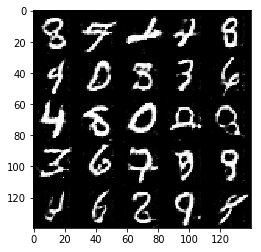

Epoch 3/4; Discriminator Loss: 1.3792; Generator Loss: 0.6264
Epoch 3/4; Discriminator Loss: 1.4371; Generator Loss: 0.5262
Epoch 3/4; Discriminator Loss: 1.5870; Generator Loss: 0.3953
Epoch 3/4; Discriminator Loss: 1.9829; Generator Loss: 0.2401
Epoch 3/4; Discriminator Loss: 1.2760; Generator Loss: 0.7004
Epoch 3/4; Discriminator Loss: 1.4624; Generator Loss: 0.4963
Epoch 3/4; Discriminator Loss: 1.4207; Generator Loss: 0.5896
Epoch 3/4; Discriminator Loss: 1.4556; Generator Loss: 1.0192
Epoch 3/4; Discriminator Loss: 1.3019; Generator Loss: 0.7086
Epoch 3/4; Discriminator Loss: 1.3602; Generator Loss: 0.7357


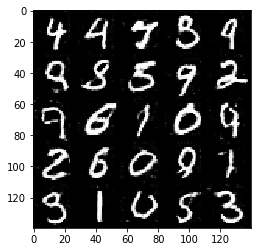

Epoch 4/4; Discriminator Loss: 1.2634; Generator Loss: 0.7210
Epoch 4/4; Discriminator Loss: 1.5076; Generator Loss: 1.0072
Epoch 4/4; Discriminator Loss: 1.4342; Generator Loss: 0.7822
Epoch 4/4; Discriminator Loss: 1.4025; Generator Loss: 0.9833
Epoch 4/4; Discriminator Loss: 1.4225; Generator Loss: 0.5451
Epoch 4/4; Discriminator Loss: 1.4131; Generator Loss: 0.5222
Epoch 4/4; Discriminator Loss: 1.5238; Generator Loss: 0.4778
Epoch 4/4; Discriminator Loss: 1.3415; Generator Loss: 0.5700
Epoch 4/4; Discriminator Loss: 1.3820; Generator Loss: 0.6653
Epoch 4/4; Discriminator Loss: 1.5111; Generator Loss: 0.4968


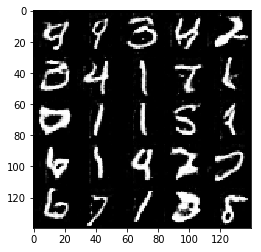

Epoch 4/4; Discriminator Loss: 1.4617; Generator Loss: 0.5233
Epoch 4/4; Discriminator Loss: 1.3198; Generator Loss: 0.7672
Epoch 4/4; Discriminator Loss: 1.3726; Generator Loss: 0.6328
Epoch 4/4; Discriminator Loss: 1.3222; Generator Loss: 0.5763
Epoch 4/4; Discriminator Loss: 1.7300; Generator Loss: 0.9114
Epoch 4/4; Discriminator Loss: 1.4220; Generator Loss: 0.5667
Epoch 4/4; Discriminator Loss: 1.4061; Generator Loss: 0.8230
Epoch 4/4; Discriminator Loss: 1.3526; Generator Loss: 0.7205
Epoch 4/4; Discriminator Loss: 1.5821; Generator Loss: 0.4224
Epoch 4/4; Discriminator Loss: 1.3077; Generator Loss: 1.0491


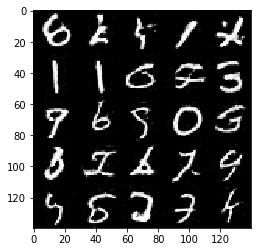

Epoch 4/4; Discriminator Loss: 1.4177; Generator Loss: 0.6096
Epoch 4/4; Discriminator Loss: 1.2968; Generator Loss: 1.3556
Epoch 4/4; Discriminator Loss: 1.3204; Generator Loss: 0.7928
Epoch 4/4; Discriminator Loss: 1.3656; Generator Loss: 0.6730
Epoch 4/4; Discriminator Loss: 1.5687; Generator Loss: 0.4181
Epoch 4/4; Discriminator Loss: 1.4591; Generator Loss: 0.5656
Epoch 4/4; Discriminator Loss: 1.3523; Generator Loss: 0.6622
Epoch 4/4; Discriminator Loss: 2.1765; Generator Loss: 0.2030
Epoch 4/4; Discriminator Loss: 1.4584; Generator Loss: 0.5590
Epoch 4/4; Discriminator Loss: 1.3892; Generator Loss: 0.7241


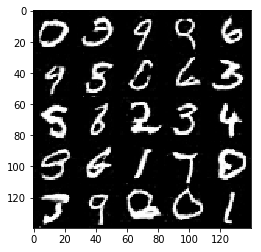

Epoch 4/4; Discriminator Loss: 1.4082; Generator Loss: 0.5611
Epoch 4/4; Discriminator Loss: 1.3961; Generator Loss: 0.7500
Epoch 4/4; Discriminator Loss: 1.3575; Generator Loss: 0.7686
Epoch 4/4; Discriminator Loss: 1.2855; Generator Loss: 0.7497
Epoch 4/4; Discriminator Loss: 1.3895; Generator Loss: 0.6864
Epoch 4/4; Discriminator Loss: 1.5459; Generator Loss: 0.4076
Epoch 4/4; Discriminator Loss: 1.5339; Generator Loss: 0.4629
Epoch 4/4; Discriminator Loss: 1.3558; Generator Loss: 0.6507
Epoch 4/4; Discriminator Loss: 1.4058; Generator Loss: 0.5317
Epoch 4/4; Discriminator Loss: 1.3467; Generator Loss: 0.6068


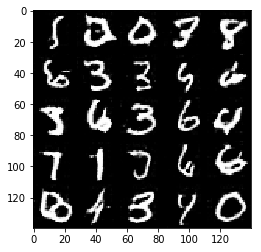

Epoch 4/4; Discriminator Loss: 1.7946; Generator Loss: 0.3085
Epoch 4/4; Discriminator Loss: 1.4402; Generator Loss: 0.7387
Epoch 4/4; Discriminator Loss: 1.3248; Generator Loss: 1.2104
Epoch 4/4; Discriminator Loss: 1.4626; Generator Loss: 0.6774
Epoch 4/4; Discriminator Loss: 1.5681; Generator Loss: 0.5655
Epoch 4/4; Discriminator Loss: 2.5286; Generator Loss: 0.1456
Epoch 4/4; Discriminator Loss: 1.2786; Generator Loss: 0.7156


In [44]:
# batch_size  = 100
# z_dim = 100
# learning_rate = 0.001
# beta1 = 0.5
batch_size  = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2; Discriminator Loss: 2.4815; Generator Loss: 0.3587
Epoch 1/2; Discriminator Loss: 3.0377; Generator Loss: 0.2874
Epoch 1/2; Discriminator Loss: 2.6429; Generator Loss: 0.3177
Epoch 1/2; Discriminator Loss: 2.2695; Generator Loss: 0.4576
Epoch 1/2; Discriminator Loss: 2.3919; Generator Loss: 0.3716
Epoch 1/2; Discriminator Loss: 2.1903; Generator Loss: 0.3658
Epoch 1/2; Discriminator Loss: 2.3051; Generator Loss: 0.4047
Epoch 1/2; Discriminator Loss: 2.0435; Generator Loss: 0.4951
Epoch 1/2; Discriminator Loss: 1.9301; Generator Loss: 0.5510
Epoch 1/2; Discriminator Loss: 1.8271; Generator Loss: 0.5742


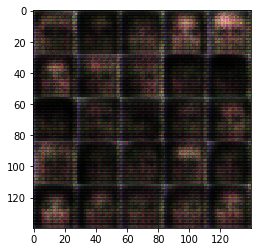

Epoch 1/2; Discriminator Loss: 1.7787; Generator Loss: 0.6013
Epoch 1/2; Discriminator Loss: 1.7617; Generator Loss: 0.6529
Epoch 1/2; Discriminator Loss: 1.7007; Generator Loss: 0.5487
Epoch 1/2; Discriminator Loss: 1.6718; Generator Loss: 0.6409
Epoch 1/2; Discriminator Loss: 1.6357; Generator Loss: 0.6413
Epoch 1/2; Discriminator Loss: 1.6567; Generator Loss: 0.6368
Epoch 1/2; Discriminator Loss: 1.6528; Generator Loss: 0.6036
Epoch 1/2; Discriminator Loss: 1.6542; Generator Loss: 0.6798
Epoch 1/2; Discriminator Loss: 1.6385; Generator Loss: 0.6635
Epoch 1/2; Discriminator Loss: 1.6590; Generator Loss: 0.6438


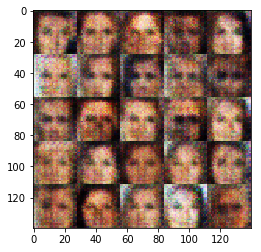

Epoch 1/2; Discriminator Loss: 1.5135; Generator Loss: 0.6859
Epoch 1/2; Discriminator Loss: 1.5717; Generator Loss: 0.6509
Epoch 1/2; Discriminator Loss: 1.6102; Generator Loss: 0.6304
Epoch 1/2; Discriminator Loss: 1.5782; Generator Loss: 0.6403
Epoch 1/2; Discriminator Loss: 1.5365; Generator Loss: 0.7019
Epoch 1/2; Discriminator Loss: 1.5859; Generator Loss: 0.6592
Epoch 1/2; Discriminator Loss: 1.5095; Generator Loss: 0.7200
Epoch 1/2; Discriminator Loss: 1.4844; Generator Loss: 0.6966
Epoch 1/2; Discriminator Loss: 1.5236; Generator Loss: 0.6798
Epoch 1/2; Discriminator Loss: 1.5568; Generator Loss: 0.6922


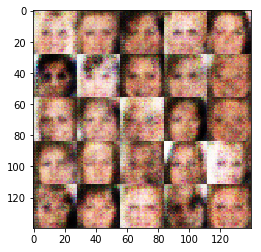

Epoch 1/2; Discriminator Loss: 1.5023; Generator Loss: 0.7246
Epoch 1/2; Discriminator Loss: 1.5129; Generator Loss: 0.6858
Epoch 1/2; Discriminator Loss: 1.5842; Generator Loss: 0.6508
Epoch 1/2; Discriminator Loss: 1.5948; Generator Loss: 0.6909
Epoch 1/2; Discriminator Loss: 1.5560; Generator Loss: 0.6740
Epoch 1/2; Discriminator Loss: 1.6768; Generator Loss: 0.6190
Epoch 1/2; Discriminator Loss: 1.5636; Generator Loss: 0.7250
Epoch 1/2; Discriminator Loss: 1.5461; Generator Loss: 0.7064
Epoch 1/2; Discriminator Loss: 1.5050; Generator Loss: 0.7323
Epoch 1/2; Discriminator Loss: 1.5709; Generator Loss: 0.7452


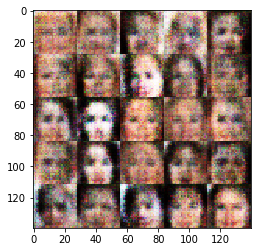

Epoch 1/2; Discriminator Loss: 1.4381; Generator Loss: 0.7436
Epoch 1/2; Discriminator Loss: 1.4919; Generator Loss: 0.7308
Epoch 1/2; Discriminator Loss: 1.5597; Generator Loss: 0.6501
Epoch 1/2; Discriminator Loss: 1.5156; Generator Loss: 0.7465
Epoch 1/2; Discriminator Loss: 1.4996; Generator Loss: 0.7337
Epoch 1/2; Discriminator Loss: 1.5347; Generator Loss: 0.7143
Epoch 1/2; Discriminator Loss: 1.4972; Generator Loss: 0.6830
Epoch 1/2; Discriminator Loss: 1.4746; Generator Loss: 0.7397
Epoch 1/2; Discriminator Loss: 1.5088; Generator Loss: 0.6844
Epoch 1/2; Discriminator Loss: 1.4831; Generator Loss: 0.7251


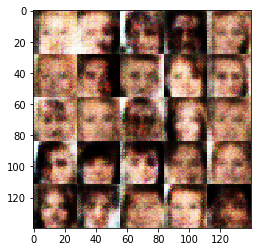

Epoch 1/2; Discriminator Loss: 1.4696; Generator Loss: 0.7329
Epoch 1/2; Discriminator Loss: 1.4558; Generator Loss: 0.7501
Epoch 1/2; Discriminator Loss: 1.4205; Generator Loss: 0.8120
Epoch 1/2; Discriminator Loss: 1.4628; Generator Loss: 0.7499
Epoch 1/2; Discriminator Loss: 1.4621; Generator Loss: 0.7055
Epoch 1/2; Discriminator Loss: 1.4912; Generator Loss: 0.6998
Epoch 1/2; Discriminator Loss: 1.5100; Generator Loss: 0.7162
Epoch 1/2; Discriminator Loss: 1.5156; Generator Loss: 0.7112
Epoch 1/2; Discriminator Loss: 1.4484; Generator Loss: 0.7199
Epoch 1/2; Discriminator Loss: 1.4956; Generator Loss: 0.7076


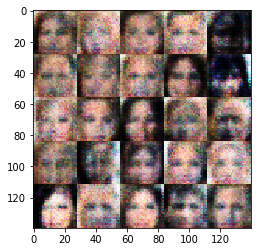

Epoch 1/2; Discriminator Loss: 1.4744; Generator Loss: 0.7484
Epoch 1/2; Discriminator Loss: 1.4764; Generator Loss: 0.7779
Epoch 1/2; Discriminator Loss: 1.4361; Generator Loss: 0.8651
Epoch 1/2; Discriminator Loss: 1.4439; Generator Loss: 0.7433
Epoch 1/2; Discriminator Loss: 1.5064; Generator Loss: 0.7034
Epoch 1/2; Discriminator Loss: 1.4953; Generator Loss: 0.6915
Epoch 1/2; Discriminator Loss: 1.4239; Generator Loss: 0.7932
Epoch 1/2; Discriminator Loss: 1.4821; Generator Loss: 0.6915
Epoch 1/2; Discriminator Loss: 1.4965; Generator Loss: 0.6941
Epoch 1/2; Discriminator Loss: 1.4601; Generator Loss: 0.7055


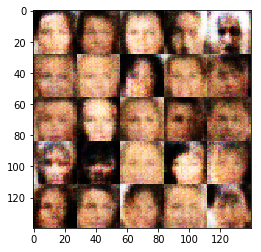

Epoch 1/2; Discriminator Loss: 1.4463; Generator Loss: 0.7278
Epoch 1/2; Discriminator Loss: 1.4419; Generator Loss: 0.7730
Epoch 1/2; Discriminator Loss: 1.4689; Generator Loss: 0.7861
Epoch 1/2; Discriminator Loss: 1.4758; Generator Loss: 0.7204
Epoch 1/2; Discriminator Loss: 1.4871; Generator Loss: 0.7585
Epoch 1/2; Discriminator Loss: 1.4274; Generator Loss: 0.7475
Epoch 1/2; Discriminator Loss: 1.4547; Generator Loss: 0.7226
Epoch 1/2; Discriminator Loss: 1.4566; Generator Loss: 0.7258
Epoch 1/2; Discriminator Loss: 1.4624; Generator Loss: 0.7249
Epoch 1/2; Discriminator Loss: 1.4330; Generator Loss: 0.7691


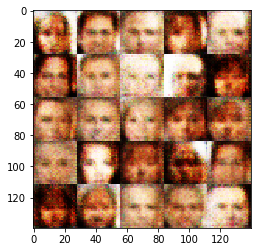

Epoch 1/2; Discriminator Loss: 1.4622; Generator Loss: 0.7878
Epoch 1/2; Discriminator Loss: 1.4469; Generator Loss: 0.7484
Epoch 1/2; Discriminator Loss: 1.4166; Generator Loss: 0.7852
Epoch 1/2; Discriminator Loss: 1.5286; Generator Loss: 0.6848
Epoch 1/2; Discriminator Loss: 1.4061; Generator Loss: 0.7307
Epoch 1/2; Discriminator Loss: 1.4848; Generator Loss: 0.7457
Epoch 1/2; Discriminator Loss: 1.5253; Generator Loss: 0.7684
Epoch 1/2; Discriminator Loss: 1.4146; Generator Loss: 0.7935
Epoch 1/2; Discriminator Loss: 1.3828; Generator Loss: 0.7659
Epoch 1/2; Discriminator Loss: 1.4114; Generator Loss: 0.7760


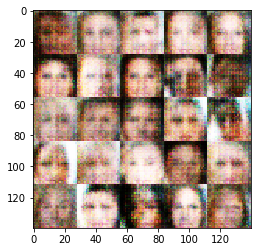

Epoch 1/2; Discriminator Loss: 1.4670; Generator Loss: 0.7258
Epoch 1/2; Discriminator Loss: 1.4243; Generator Loss: 0.8058
Epoch 1/2; Discriminator Loss: 1.4141; Generator Loss: 0.7788
Epoch 1/2; Discriminator Loss: 1.4476; Generator Loss: 0.7423
Epoch 1/2; Discriminator Loss: 1.4190; Generator Loss: 0.7049
Epoch 1/2; Discriminator Loss: 1.4384; Generator Loss: 0.7094
Epoch 1/2; Discriminator Loss: 1.4083; Generator Loss: 0.7270
Epoch 1/2; Discriminator Loss: 1.4087; Generator Loss: 0.7834
Epoch 1/2; Discriminator Loss: 1.4888; Generator Loss: 0.7472
Epoch 1/2; Discriminator Loss: 1.4782; Generator Loss: 0.7757


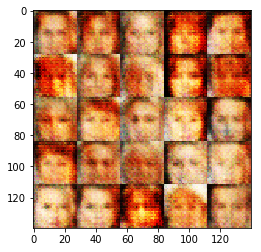

Epoch 1/2; Discriminator Loss: 1.4566; Generator Loss: 0.7251
Epoch 1/2; Discriminator Loss: 1.4124; Generator Loss: 0.7485
Epoch 1/2; Discriminator Loss: 1.4300; Generator Loss: 0.7756
Epoch 1/2; Discriminator Loss: 1.4439; Generator Loss: 0.7776
Epoch 1/2; Discriminator Loss: 1.4412; Generator Loss: 0.7335
Epoch 1/2; Discriminator Loss: 1.4596; Generator Loss: 0.7471
Epoch 1/2; Discriminator Loss: 1.4752; Generator Loss: 0.7174
Epoch 1/2; Discriminator Loss: 1.4048; Generator Loss: 0.8085
Epoch 1/2; Discriminator Loss: 1.4120; Generator Loss: 0.7861
Epoch 1/2; Discriminator Loss: 1.4350; Generator Loss: 0.7809


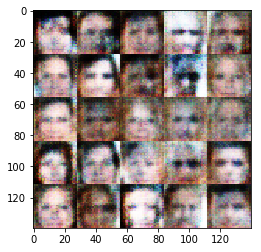

Epoch 1/2; Discriminator Loss: 1.4162; Generator Loss: 0.7712
Epoch 1/2; Discriminator Loss: 1.4780; Generator Loss: 0.7505
Epoch 1/2; Discriminator Loss: 1.4473; Generator Loss: 0.7291
Epoch 1/2; Discriminator Loss: 1.4249; Generator Loss: 0.7372
Epoch 1/2; Discriminator Loss: 1.4044; Generator Loss: 0.8151
Epoch 1/2; Discriminator Loss: 1.4476; Generator Loss: 0.7328
Epoch 1/2; Discriminator Loss: 1.4389; Generator Loss: 0.7659
Epoch 1/2; Discriminator Loss: 1.4169; Generator Loss: 0.7786
Epoch 1/2; Discriminator Loss: 1.4160; Generator Loss: 0.7588
Epoch 1/2; Discriminator Loss: 1.4534; Generator Loss: 0.7513


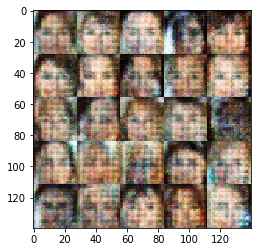

Epoch 1/2; Discriminator Loss: 1.4033; Generator Loss: 0.8069
Epoch 1/2; Discriminator Loss: 1.4300; Generator Loss: 0.7724
Epoch 1/2; Discriminator Loss: 1.4329; Generator Loss: 0.7695
Epoch 1/2; Discriminator Loss: 1.4102; Generator Loss: 0.7881
Epoch 1/2; Discriminator Loss: 1.4498; Generator Loss: 0.7386
Epoch 1/2; Discriminator Loss: 1.4315; Generator Loss: 0.7772
Epoch 1/2; Discriminator Loss: 1.4309; Generator Loss: 0.7703
Epoch 1/2; Discriminator Loss: 1.4310; Generator Loss: 0.8107
Epoch 1/2; Discriminator Loss: 1.4753; Generator Loss: 0.7250
Epoch 1/2; Discriminator Loss: 1.5002; Generator Loss: 0.8083


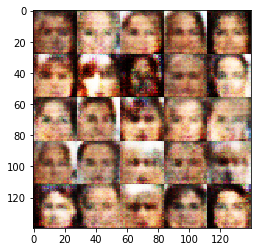

Epoch 1/2; Discriminator Loss: 1.4502; Generator Loss: 0.7500
Epoch 1/2; Discriminator Loss: 1.4410; Generator Loss: 0.7456
Epoch 1/2; Discriminator Loss: 1.4236; Generator Loss: 0.7523
Epoch 1/2; Discriminator Loss: 1.4558; Generator Loss: 0.7841
Epoch 1/2; Discriminator Loss: 1.4795; Generator Loss: 0.7317
Epoch 1/2; Discriminator Loss: 1.4382; Generator Loss: 0.7716
Epoch 1/2; Discriminator Loss: 1.4056; Generator Loss: 0.8060
Epoch 1/2; Discriminator Loss: 1.4191; Generator Loss: 0.7511
Epoch 1/2; Discriminator Loss: 1.4198; Generator Loss: 0.7370
Epoch 1/2; Discriminator Loss: 1.4612; Generator Loss: 0.7461


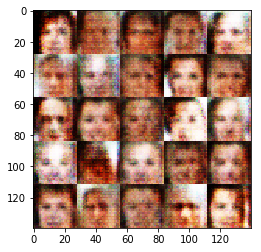

Epoch 1/2; Discriminator Loss: 1.4502; Generator Loss: 0.7619
Epoch 1/2; Discriminator Loss: 1.4143; Generator Loss: 0.7439
Epoch 1/2; Discriminator Loss: 1.4423; Generator Loss: 0.7753
Epoch 1/2; Discriminator Loss: 1.4313; Generator Loss: 0.7492
Epoch 1/2; Discriminator Loss: 1.4198; Generator Loss: 0.7860
Epoch 1/2; Discriminator Loss: 1.4346; Generator Loss: 0.7491
Epoch 1/2; Discriminator Loss: 1.4099; Generator Loss: 0.7564
Epoch 1/2; Discriminator Loss: 1.4066; Generator Loss: 0.7547
Epoch 1/2; Discriminator Loss: 1.4051; Generator Loss: 0.7972
Epoch 1/2; Discriminator Loss: 1.4412; Generator Loss: 0.7397


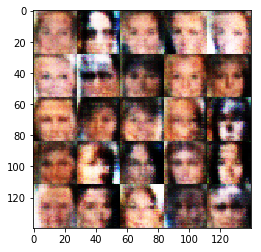

Epoch 1/2; Discriminator Loss: 1.4180; Generator Loss: 0.7645
Epoch 1/2; Discriminator Loss: 1.3945; Generator Loss: 0.8215
Epoch 1/2; Discriminator Loss: 1.4174; Generator Loss: 0.7816
Epoch 1/2; Discriminator Loss: 1.4287; Generator Loss: 0.7680
Epoch 1/2; Discriminator Loss: 1.4202; Generator Loss: 0.7548
Epoch 1/2; Discriminator Loss: 1.4183; Generator Loss: 0.7644
Epoch 1/2; Discriminator Loss: 1.3926; Generator Loss: 0.7526
Epoch 1/2; Discriminator Loss: 1.4108; Generator Loss: 0.7733
Epoch 2/2; Discriminator Loss: 1.4215; Generator Loss: 0.7441
Epoch 2/2; Discriminator Loss: 1.4089; Generator Loss: 0.7760


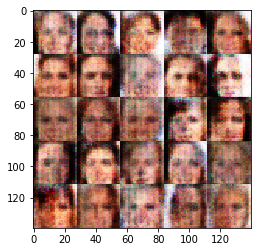

Epoch 2/2; Discriminator Loss: 1.4115; Generator Loss: 0.7666
Epoch 2/2; Discriminator Loss: 1.4424; Generator Loss: 0.7400
Epoch 2/2; Discriminator Loss: 1.4351; Generator Loss: 0.7781
Epoch 2/2; Discriminator Loss: 1.4079; Generator Loss: 0.7848
Epoch 2/2; Discriminator Loss: 1.4426; Generator Loss: 0.7163
Epoch 2/2; Discriminator Loss: 1.4236; Generator Loss: 0.8082
Epoch 2/2; Discriminator Loss: 1.4049; Generator Loss: 0.7851
Epoch 2/2; Discriminator Loss: 1.4665; Generator Loss: 0.7466
Epoch 2/2; Discriminator Loss: 1.4388; Generator Loss: 0.7387
Epoch 2/2; Discriminator Loss: 1.4181; Generator Loss: 0.7338


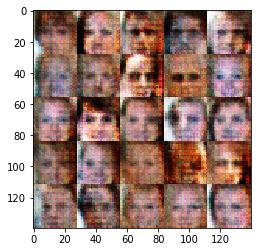

Epoch 2/2; Discriminator Loss: 1.4226; Generator Loss: 0.7957
Epoch 2/2; Discriminator Loss: 1.4012; Generator Loss: 0.8292
Epoch 2/2; Discriminator Loss: 1.4518; Generator Loss: 0.7581
Epoch 2/2; Discriminator Loss: 1.4148; Generator Loss: 0.7804
Epoch 2/2; Discriminator Loss: 1.4154; Generator Loss: 0.7852
Epoch 2/2; Discriminator Loss: 1.4002; Generator Loss: 0.7676
Epoch 2/2; Discriminator Loss: 1.4089; Generator Loss: 0.7928
Epoch 2/2; Discriminator Loss: 1.4343; Generator Loss: 0.7293
Epoch 2/2; Discriminator Loss: 1.4465; Generator Loss: 0.7642
Epoch 2/2; Discriminator Loss: 1.4203; Generator Loss: 0.7426


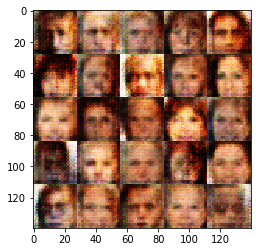

Epoch 2/2; Discriminator Loss: 1.3994; Generator Loss: 0.7639
Epoch 2/2; Discriminator Loss: 1.4122; Generator Loss: 0.8153
Epoch 2/2; Discriminator Loss: 1.4130; Generator Loss: 0.7986
Epoch 2/2; Discriminator Loss: 1.4102; Generator Loss: 0.8074
Epoch 2/2; Discriminator Loss: 1.3973; Generator Loss: 0.7853
Epoch 2/2; Discriminator Loss: 1.4160; Generator Loss: 0.7533
Epoch 2/2; Discriminator Loss: 1.4015; Generator Loss: 0.7602
Epoch 2/2; Discriminator Loss: 1.3901; Generator Loss: 0.7834
Epoch 2/2; Discriminator Loss: 1.4286; Generator Loss: 0.7409
Epoch 2/2; Discriminator Loss: 1.4277; Generator Loss: 0.7753


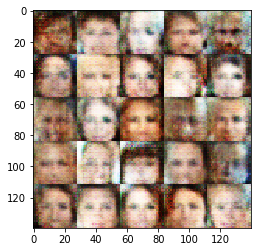

Epoch 2/2; Discriminator Loss: 1.4355; Generator Loss: 0.7468
Epoch 2/2; Discriminator Loss: 1.4156; Generator Loss: 0.7782
Epoch 2/2; Discriminator Loss: 1.4143; Generator Loss: 0.7763
Epoch 2/2; Discriminator Loss: 1.4140; Generator Loss: 0.7396
Epoch 2/2; Discriminator Loss: 1.3958; Generator Loss: 0.7505
Epoch 2/2; Discriminator Loss: 1.3759; Generator Loss: 0.7695
Epoch 2/2; Discriminator Loss: 1.4153; Generator Loss: 0.7989
Epoch 2/2; Discriminator Loss: 1.4482; Generator Loss: 0.7374
Epoch 2/2; Discriminator Loss: 1.4057; Generator Loss: 0.8141
Epoch 2/2; Discriminator Loss: 1.4161; Generator Loss: 0.7453


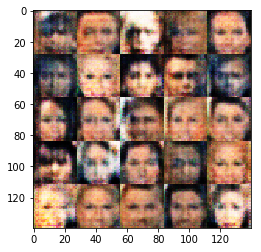

Epoch 2/2; Discriminator Loss: 1.4554; Generator Loss: 0.7214
Epoch 2/2; Discriminator Loss: 1.5127; Generator Loss: 0.7052
Epoch 2/2; Discriminator Loss: 1.5350; Generator Loss: 0.7401
Epoch 2/2; Discriminator Loss: 1.3848; Generator Loss: 0.7554
Epoch 2/2; Discriminator Loss: 1.3949; Generator Loss: 0.7723
Epoch 2/2; Discriminator Loss: 1.3773; Generator Loss: 0.7449
Epoch 2/2; Discriminator Loss: 1.4040; Generator Loss: 0.7954
Epoch 2/2; Discriminator Loss: 1.4314; Generator Loss: 0.7447
Epoch 2/2; Discriminator Loss: 1.4103; Generator Loss: 0.7742
Epoch 2/2; Discriminator Loss: 1.4382; Generator Loss: 0.7482


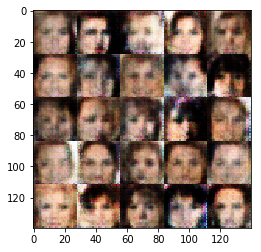

Epoch 2/2; Discriminator Loss: 1.4080; Generator Loss: 0.7824
Epoch 2/2; Discriminator Loss: 1.4064; Generator Loss: 0.7641
Epoch 2/2; Discriminator Loss: 1.4092; Generator Loss: 0.7721
Epoch 2/2; Discriminator Loss: 1.4114; Generator Loss: 0.8049
Epoch 2/2; Discriminator Loss: 1.5177; Generator Loss: 0.7072
Epoch 2/2; Discriminator Loss: 1.4206; Generator Loss: 0.8009
Epoch 2/2; Discriminator Loss: 1.4302; Generator Loss: 0.7425
Epoch 2/2; Discriminator Loss: 1.4344; Generator Loss: 0.7766
Epoch 2/2; Discriminator Loss: 1.4202; Generator Loss: 0.7918
Epoch 2/2; Discriminator Loss: 1.3852; Generator Loss: 0.7705


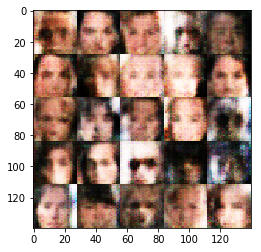

Epoch 2/2; Discriminator Loss: 1.4214; Generator Loss: 0.7248
Epoch 2/2; Discriminator Loss: 1.3957; Generator Loss: 0.8016
Epoch 2/2; Discriminator Loss: 1.4088; Generator Loss: 0.8044
Epoch 2/2; Discriminator Loss: 1.4316; Generator Loss: 0.8020
Epoch 2/2; Discriminator Loss: 1.4559; Generator Loss: 0.7656
Epoch 2/2; Discriminator Loss: 1.4428; Generator Loss: 0.7656
Epoch 2/2; Discriminator Loss: 1.4584; Generator Loss: 0.7737
Epoch 2/2; Discriminator Loss: 1.4320; Generator Loss: 0.8035
Epoch 2/2; Discriminator Loss: 1.4020; Generator Loss: 0.7792
Epoch 2/2; Discriminator Loss: 1.4329; Generator Loss: 0.7335


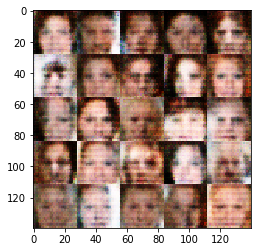

Epoch 2/2; Discriminator Loss: 1.4240; Generator Loss: 0.7340
Epoch 2/2; Discriminator Loss: 1.4210; Generator Loss: 0.7512
Epoch 2/2; Discriminator Loss: 1.4167; Generator Loss: 0.7704
Epoch 2/2; Discriminator Loss: 1.4193; Generator Loss: 0.7799
Epoch 2/2; Discriminator Loss: 1.3924; Generator Loss: 0.7499
Epoch 2/2; Discriminator Loss: 1.4106; Generator Loss: 0.7910
Epoch 2/2; Discriminator Loss: 1.4372; Generator Loss: 0.7575
Epoch 2/2; Discriminator Loss: 1.3838; Generator Loss: 0.7762
Epoch 2/2; Discriminator Loss: 1.4005; Generator Loss: 0.7912
Epoch 2/2; Discriminator Loss: 1.4102; Generator Loss: 0.7663


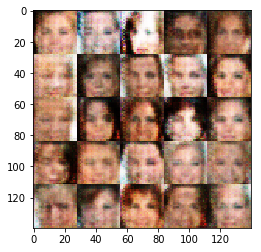

Epoch 2/2; Discriminator Loss: 1.3992; Generator Loss: 0.7891
Epoch 2/2; Discriminator Loss: 1.3858; Generator Loss: 0.7867
Epoch 2/2; Discriminator Loss: 1.4082; Generator Loss: 0.7982
Epoch 2/2; Discriminator Loss: 1.3757; Generator Loss: 0.8085
Epoch 2/2; Discriminator Loss: 1.3931; Generator Loss: 0.7597
Epoch 2/2; Discriminator Loss: 1.4396; Generator Loss: 0.7524
Epoch 2/2; Discriminator Loss: 1.4020; Generator Loss: 0.7804
Epoch 2/2; Discriminator Loss: 1.4549; Generator Loss: 0.7295
Epoch 2/2; Discriminator Loss: 1.4025; Generator Loss: 0.7981
Epoch 2/2; Discriminator Loss: 1.3999; Generator Loss: 0.7255


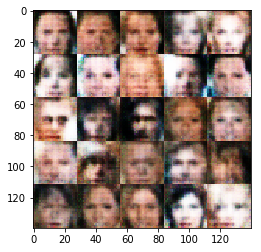

Epoch 2/2; Discriminator Loss: 1.4133; Generator Loss: 0.7597
Epoch 2/2; Discriminator Loss: 1.4234; Generator Loss: 0.7876
Epoch 2/2; Discriminator Loss: 1.4167; Generator Loss: 0.7552
Epoch 2/2; Discriminator Loss: 1.4155; Generator Loss: 0.7714
Epoch 2/2; Discriminator Loss: 1.4294; Generator Loss: 0.7762
Epoch 2/2; Discriminator Loss: 1.4633; Generator Loss: 0.7769
Epoch 2/2; Discriminator Loss: 1.5154; Generator Loss: 0.7063
Epoch 2/2; Discriminator Loss: 1.4078; Generator Loss: 0.8019
Epoch 2/2; Discriminator Loss: 1.4164; Generator Loss: 0.7728
Epoch 2/2; Discriminator Loss: 1.4045; Generator Loss: 0.7363


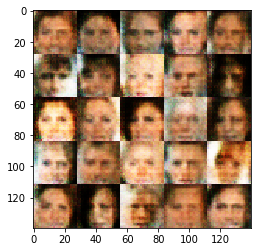

Epoch 2/2; Discriminator Loss: 1.4141; Generator Loss: 0.7699
Epoch 2/2; Discriminator Loss: 1.3902; Generator Loss: 0.7926
Epoch 2/2; Discriminator Loss: 1.4089; Generator Loss: 0.7587
Epoch 2/2; Discriminator Loss: 1.4075; Generator Loss: 0.7845
Epoch 2/2; Discriminator Loss: 1.3628; Generator Loss: 0.8117
Epoch 2/2; Discriminator Loss: 1.3847; Generator Loss: 0.8012
Epoch 2/2; Discriminator Loss: 1.3869; Generator Loss: 0.8220
Epoch 2/2; Discriminator Loss: 1.4380; Generator Loss: 0.7489
Epoch 2/2; Discriminator Loss: 1.4160; Generator Loss: 0.7262
Epoch 2/2; Discriminator Loss: 1.4391; Generator Loss: 0.7627


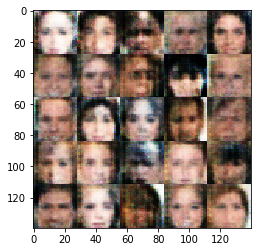

Epoch 2/2; Discriminator Loss: 1.4210; Generator Loss: 0.7643
Epoch 2/2; Discriminator Loss: 1.4049; Generator Loss: 0.7956
Epoch 2/2; Discriminator Loss: 1.3947; Generator Loss: 0.7623
Epoch 2/2; Discriminator Loss: 1.4034; Generator Loss: 0.7693
Epoch 2/2; Discriminator Loss: 1.4190; Generator Loss: 0.7549
Epoch 2/2; Discriminator Loss: 1.3894; Generator Loss: 0.8203
Epoch 2/2; Discriminator Loss: 1.4269; Generator Loss: 0.7393
Epoch 2/2; Discriminator Loss: 1.4022; Generator Loss: 0.7790
Epoch 2/2; Discriminator Loss: 1.4142; Generator Loss: 0.7524
Epoch 2/2; Discriminator Loss: 1.4122; Generator Loss: 0.7323


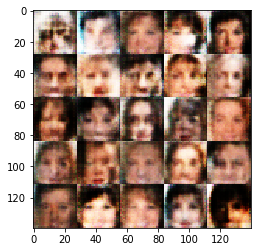

Epoch 2/2; Discriminator Loss: 1.4123; Generator Loss: 0.7607
Epoch 2/2; Discriminator Loss: 1.4522; Generator Loss: 0.7356
Epoch 2/2; Discriminator Loss: 1.4039; Generator Loss: 0.7486
Epoch 2/2; Discriminator Loss: 1.3870; Generator Loss: 0.7733
Epoch 2/2; Discriminator Loss: 1.3831; Generator Loss: 0.7700
Epoch 2/2; Discriminator Loss: 1.3790; Generator Loss: 0.7561
Epoch 2/2; Discriminator Loss: 1.3891; Generator Loss: 0.8308
Epoch 2/2; Discriminator Loss: 1.4312; Generator Loss: 0.7406
Epoch 2/2; Discriminator Loss: 1.4267; Generator Loss: 0.7725
Epoch 2/2; Discriminator Loss: 1.4210; Generator Loss: 0.7587


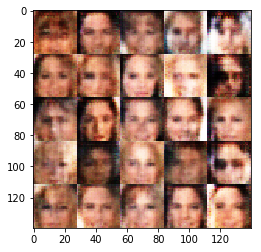

Epoch 2/2; Discriminator Loss: 1.4103; Generator Loss: 0.7626
Epoch 2/2; Discriminator Loss: 1.4074; Generator Loss: 0.7547
Epoch 2/2; Discriminator Loss: 1.4301; Generator Loss: 0.7720
Epoch 2/2; Discriminator Loss: 1.4009; Generator Loss: 0.7940
Epoch 2/2; Discriminator Loss: 1.4313; Generator Loss: 0.7626
Epoch 2/2; Discriminator Loss: 1.3867; Generator Loss: 0.8122
Epoch 2/2; Discriminator Loss: 1.4056; Generator Loss: 0.7739
Epoch 2/2; Discriminator Loss: 1.4169; Generator Loss: 0.7332
Epoch 2/2; Discriminator Loss: 1.4237; Generator Loss: 0.7655
Epoch 2/2; Discriminator Loss: 1.4011; Generator Loss: 0.7600


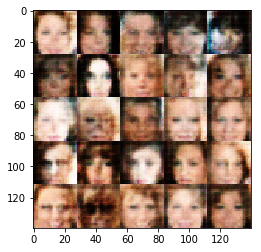

Epoch 2/2; Discriminator Loss: 1.4004; Generator Loss: 0.8203
Epoch 2/2; Discriminator Loss: 1.4000; Generator Loss: 0.7719
Epoch 2/2; Discriminator Loss: 1.3965; Generator Loss: 0.7887
Epoch 2/2; Discriminator Loss: 1.3935; Generator Loss: 0.8192
Epoch 2/2; Discriminator Loss: 1.3958; Generator Loss: 0.8113
Epoch 2/2; Discriminator Loss: 1.3905; Generator Loss: 0.7739
Epoch 2/2; Discriminator Loss: 1.4083; Generator Loss: 0.7724
Epoch 2/2; Discriminator Loss: 1.3930; Generator Loss: 0.7685
Epoch 2/2; Discriminator Loss: 1.4250; Generator Loss: 0.7752
Epoch 2/2; Discriminator Loss: 1.4123; Generator Loss: 0.7602


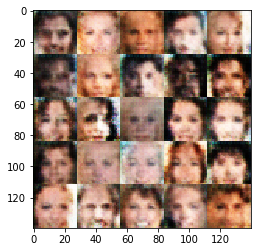

Epoch 2/2; Discriminator Loss: 1.4202; Generator Loss: 0.7651
Epoch 2/2; Discriminator Loss: 1.4202; Generator Loss: 0.7454
Epoch 2/2; Discriminator Loss: 1.4209; Generator Loss: 0.7618
Epoch 2/2; Discriminator Loss: 1.4293; Generator Loss: 0.7466
Epoch 2/2; Discriminator Loss: 1.3915; Generator Loss: 0.7706
Epoch 2/2; Discriminator Loss: 1.4021; Generator Loss: 0.7846


In [45]:
batch_size  = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.